<a href="https://colab.research.google.com/github/OrangeSunProgramming/brain-tumor-classification/blob/main/snn_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path to your 'training' directory
data_dir = '/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Training'

# Set parameters for image resizing and batch size
img_size = (128, 128)  # Resize all images to 128x128
batch_size = 32

# Load the dataset using image_dataset_from_directory with validation split
train_dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  # integer labels
    validation_split=0.2,  # 80% train, 20% validation
    subset='training',  # Use this subset for training
    seed=123,  # For reproducibility
)

val_dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  # integer labels
    validation_split=0.2,  # Must be the same as the train split
    subset='validation',  # Use this subset for validation
    seed=123,  # For reproducibility
)

class_names = train_dataset.class_names

print(f"Class names: {class_names}")

# Normalize the images (to scale pixel values between 0 and 1)
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_dataset = train_dataset.map(normalize_img).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_img).cache().prefetch(tf.data.AUTOTUNE)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [22]:
class SNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_neurons, tau=10.0, threshold=1.0, dt=1.0):
        super(SNNLayer, self).__init__()
        self.num_neurons = num_neurons
        self.tau = tau  # Time constant for membrane potential decay
        self.threshold = threshold  # Firing threshold
        self.dt = dt  # Time step for simulation
        self.synaptic_weights = None  # Synaptic weights

    def build(self, input_shape):
        input_dim = input_shape[-1]  # Get the last dimension, i.e., the number of features (channels)

        # Initialize synaptic weights with small random values
        self.synaptic_weights = self.add_weight(
            name="synaptic_weights",
            shape=(input_dim, self.num_neurons),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs, training=False):
        # Compute the input current: I = X * W
        current_input = tf.matmul(inputs, self.synaptic_weights)

        # Create the membrane potential tensor with shape (batch_size, num_neurons)
        # Initialize membrane potential dynamically based on batch size
        membrane_potential = tf.zeros([tf.shape(inputs)[0], self.num_neurons], dtype=tf.float32)

        # Update membrane potential: V = V - (1/tau) * V + I
        membrane_potential = membrane_potential - (membrane_potential / self.tau) * self.dt + current_input

        # Spike generation: Fire when the membrane potential exceeds the threshold
        spikes = tf.cast(membrane_potential >= self.threshold, tf.float32)

        # Reset potential after firing
        membrane_potential = membrane_potential * (1 - spikes)

        return spikes


# Spike-Timing Dependent Plasticity (STDP Layer)
class STDP(SNNLayer):
    def __init__(self, num_neurons, alpha_pos=0.005, alpha_neg=0.005, tau_pos=20.0, tau_neg=20.0, **kwargs):
        super(STDP, self).__init__(num_neurons, **kwargs)
        self.alpha_pos = alpha_pos
        self.alpha_neg = alpha_neg
        self.tau_pos = tau_pos
        self.tau_neg = tau_neg

    def build(self, input_shape):
        input_dim = input_shape[-1]  # Get the last dimension, i.e., the number of features (channels)

        # Initialize synaptic weights as a trainable variable
        self.synaptic_weights = self.add_weight(
            name="synaptic_weights",
            shape=(input_dim, self.num_neurons),
            initializer="glorot_uniform",
            trainable=True
        )

    @tf.function
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]

        # Dynamically initialize spike time variables based on batch size
        pre_spike_times = tf.zeros([batch_size, self.num_neurons], dtype=tf.float32)
        post_spike_times = tf.zeros([batch_size, self.num_neurons], dtype=tf.float32)
        last_spike_time = tf.zeros([1], dtype=tf.float32)

        # Call the parent class's call method for membrane potential and spike generation
        spikes = super(STDP, self).call(inputs)

        # Simulate time (accumulate time step by step)
        current_time = last_spike_time + self.dt

        # Apply STDP rule for weight updates
        spike_condition = tf.cast(spikes > 0, tf.float32)
        delta_w = self.alpha_pos * tf.exp(-(current_time - pre_spike_times) / self.tau_pos) - \
                  self.alpha_neg * tf.exp(-(current_time - post_spike_times) / self.tau_neg)

        # Flatten inputs to match the dimensions of synaptic weights
        inputs_flat = tf.reshape(inputs, [batch_size, -1])

        # Apply weight updates based on STDP
        weight_updates = tf.matmul(tf.transpose(inputs_flat), delta_w)
        self.synaptic_weights.assign_add(weight_updates)

        return spikes


In [23]:
#SNN Model definition

def build_snn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        STDP(128),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [24]:
def spike_loss(y_true, y_pred):
    # Convert spike patterns to counts and compute loss
    spike_count_true = tf.reduce_sum(y_true, axis=-1)
    spike_count_pred = tf.reduce_sum(y_pred, axis=-1)
    return tf.reduce_mean(tf.square(spike_count_true - spike_count_pred))

In [25]:
# Create the model
model = build_snn_model(input_shape=(128, 128, 3), num_classes=4)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=spike_loss,  #Use custom spike loss function
              metrics=["accuracy"])

# Model's Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stdp_1 (STDP)                        │ (None, 128)                 │       3,211,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,313,028 (12.64 MB)

 Trainable params: 3,313,028 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=25, monitor="val_loss", mode="auto")

# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'synaptic_weights'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2836 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2836 - loss:

In [27]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3060 - loss: 1900.9418
Validation Loss: 2023.9964599609375, Validation Accuracy: 0.2857142984867096


In [28]:
#Saving the training history
import pandas as pd
simple_model_history = pd.DataFrame(history.history)
simple_model_history.to_csv("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/snn_model_history.csv")

print("Training history saved!")

Training history saved!


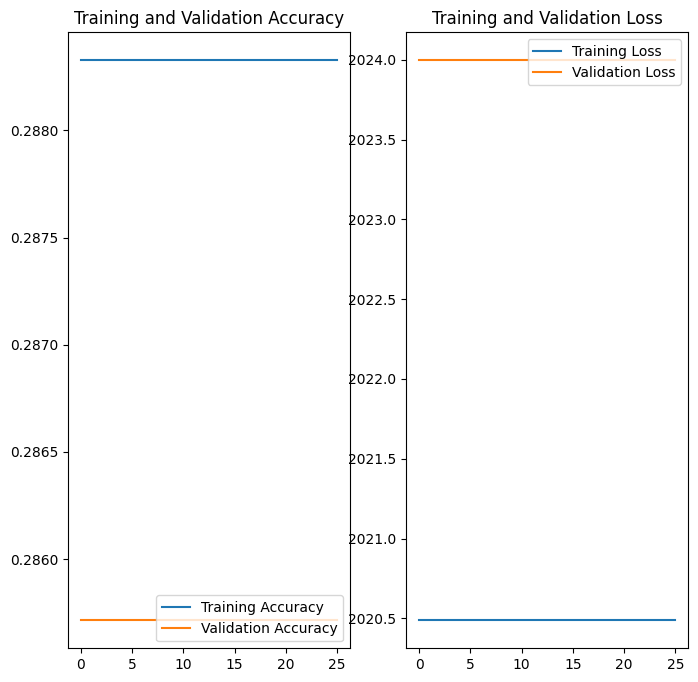

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/snn_model_results.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


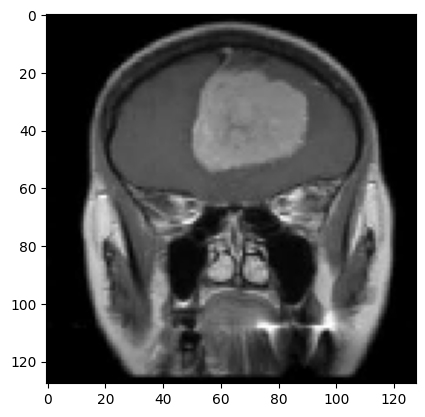

Predicted class: glioma_tumor


In [30]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image as done during training

    # Make prediction
    predictions = model.predict(img_array)

    # Display the image and predicted class
    plt.imshow(img)
    plt.show()

    print("Predicted class:", class_names[np.argmax(predictions)])

# Example of predicting a single image
predict_image("/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing/meningioma_tumor/image(21).jpg", model)